In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


---

# Ансамбли моделей

В этой работе мы рассмотрим применение некоторых классических и хорошо себя показавших алгоритмов-ансамблей. Демонстрировать работу этих алгоритмов будем на данных о потреблении электричества.

# Описание набора данных

**Author**: M. Harries, J. Gama, A. Bifet  
**Source**: [Joao Gama](http://www.inescporto.pt/~jgama/ales/ales_5.html) - 2009  
**Please cite**: None  

**Electricity** is a widely used dataset described by M. Harries and analyzed by J. Gama (see papers below). This data was collected from the Australian New South Wales Electricity Market. In this market, prices are not fixed and are affected by demand and supply of the market. They are set every five minutes. Electricity transfers to/from the neighboring state of Victoria were done to alleviate fluctuations.

The dataset (originally named ELEC2) contains 45,312 instances dated from 7 May 1996 to 5 December 1998. Each example of the dataset refers to a period of 30 minutes, i.e. there are 48 instances for each time period of one day. Each example on the dataset has 5 fields, the day of week, the time stamp, the New South Wales electricity demand, the Victoria electricity demand, the scheduled electricity transfer between states and the class label. The class label identifies the change of the price (UP or DOWN) in New South Wales relative to a moving average of the last 24 hours (and removes the impact of longer term price trends).

The data was normalized by A. Bifet.

### Attribute information  
* Date: date between 7 May 1996 to 5 December 1998. Here normalized between 0 and 1
* Day: day of the week (1-7)
* Period: time of the measurement (1-48) in half hour intervals over 24 hours. Here normalized between 0 and 1
* NSWprice: New South Wales electricity price, normalized between 0 and 1
* NSWdemand: New South Wales electricity demand, normalized between 0 and 1
* VICprice: Victoria electricity price, normalized between 0 and 1
* VICdemand: Victoria electricity demand, normalized between 0 and 1
* transfer: scheduled electricity transfer between both states, normalized between 0 and 1

### Relevant papers  
M. Harries. Splice-2 comparative evaluation: Electricity pricing. Technical report, The University of South Wales, 1999.  
J. Gama, P. Medas, G. Castillo, and P. Rodrigues. Learning with drift detection. In SBIA Brazilian Symposium on Artificial Intelligence, pages 286–295, 2004.

# Разведочный анализ данных

Считайте набор данных в датафрейм

In [2]:
df = pd.read_csv('electricity_train.csv',
                 sep=',', skipinitialspace=True, header=0)

При помощи метода <code>.describe()</code> изучите набор данных «с высоты птичьего полета».

In [3]:
df.describe()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
count,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000
mean,0.498293,4.006566,0.500560,0.057828,0.425939,0.003455,0.423024,0.500243,0.424536
std,0.339907,1.993551,0.294998,0.039052,0.163390,0.010175,0.120600,0.153098,0.494279
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.031945,2.000000,0.255319,0.035187,0.309729,0.002283,0.373382,0.414912,0.000000
50%,0.456263,4.000000,0.510638,0.048787,0.444213,0.003467,0.422915,0.414912,0.000000
75%,0.880492,6.000000,0.765957,0.074457,0.536745,0.003467,0.468669,0.605263,1.000000
max,1.000000,7.000000,1.000000,1.000000,0.980809,1.000000,1.000000,0.959211,1.000000


Убедитесь в отсутствии пропусков. Имеет смысл проверить сбалансированность классов. Введите долю элементов класса $1$.

date         0
day          0
period       0
nswprice     0
nswdemand    0
vicprice     0
vicdemand    0
transfer     0
class        0
dtype: int64
0.4245358492648073


<Axes: xlabel='class', ylabel='Count'>

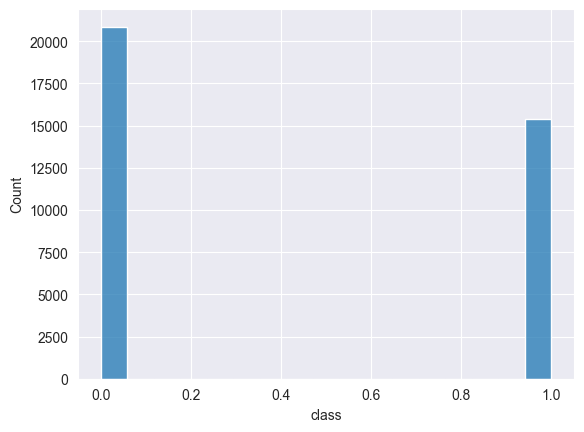

In [4]:
print(df.isna().sum())
print(df['class'].value_counts()[1]/(df['class'].value_counts()[1]+df['class'].value_counts()[0]))
sns.histplot(df['class'])

Постройте матрицу корреляций. Определите пару наиболее коррелированных признаков.

               date       day    period  nswprice  nswdemand  vicprice  \
date       1.000000  0.005840  0.001577 -0.153561   0.067692  0.002110   
day        0.005840  1.000000 -0.000416  0.003168  -0.052946  0.001082   
period     0.001577 -0.000416  1.000000  0.105341   0.444579  0.022706   
nswprice  -0.153561  0.003168  0.105341  1.000000   0.306982  0.288349   
nswdemand  0.067692 -0.052946  0.444579  0.306982   1.000000  0.083510   
vicprice   0.002110  0.001082  0.022706  0.288349   0.083510  1.000000   
vicdemand  0.057239  0.076904  0.192153  0.304492   0.667174  0.125489   
transfer   0.405853 -0.053012 -0.115437 -0.274764  -0.264476 -0.081112   
class     -0.003827 -0.046841  0.154224  0.386071   0.331741  0.065630   

           vicdemand  transfer     class  
date        0.057239  0.405853 -0.003827  
day         0.076904 -0.053012 -0.046841  
period      0.192153 -0.115437  0.154224  
nswprice    0.304492 -0.274764  0.386071  
nswdemand   0.667174 -0.264476  0.331741  
v

<Axes: >

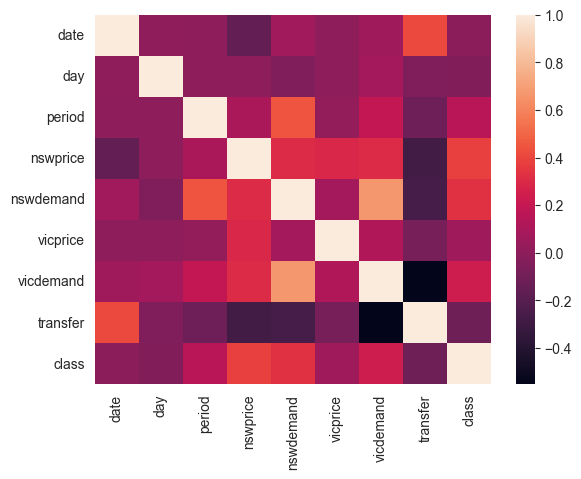

In [5]:
print(df.corr())
sns.heatmap(df.corr())

Постройте гистограммы распределений признаков.

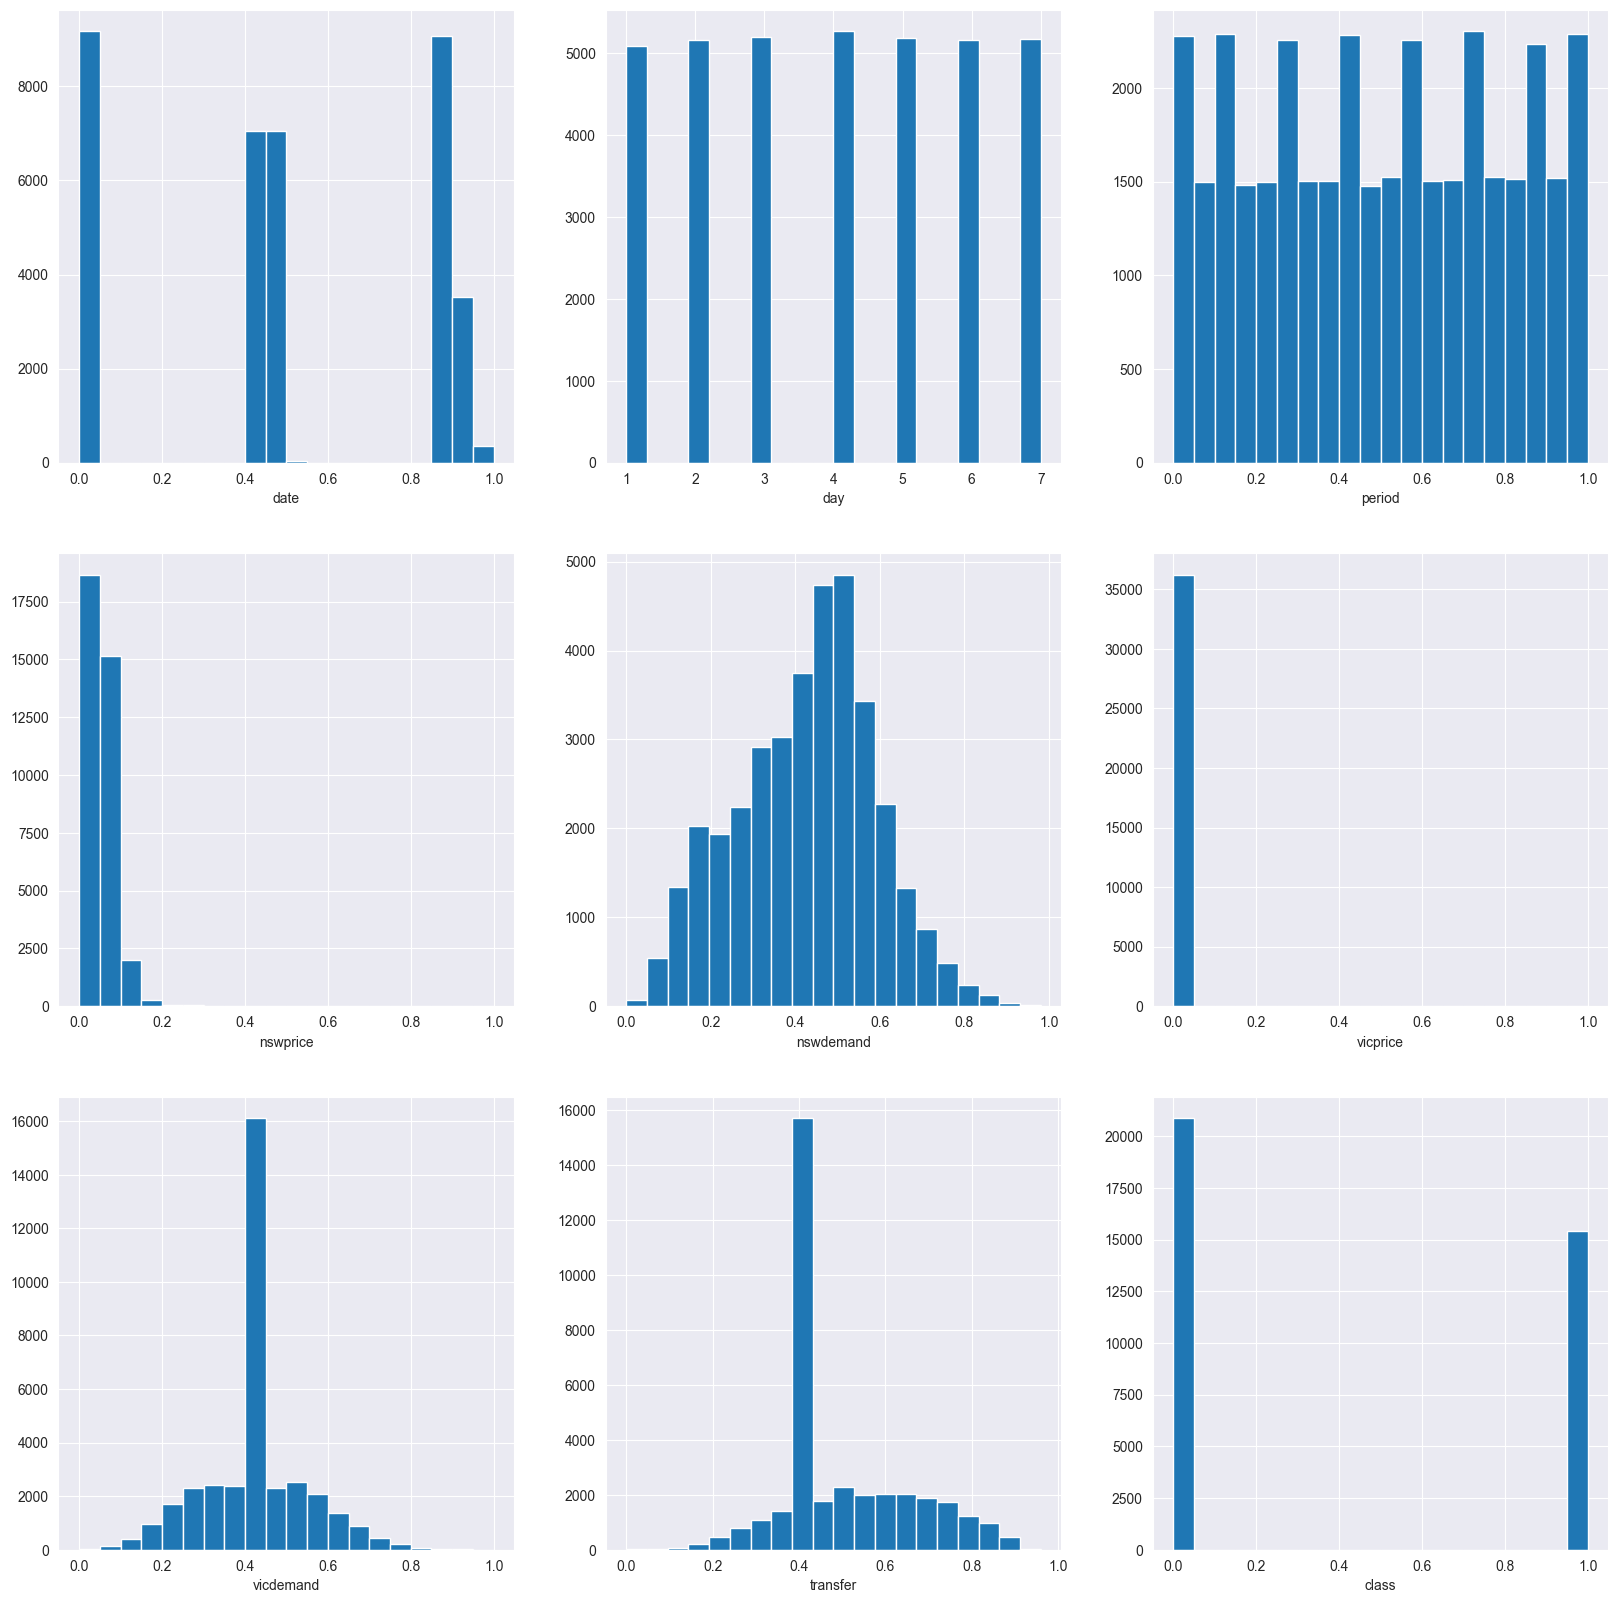

In [6]:
plt.figure(figsize=[20, 20])
cols = list(df)
for i in range(len(cols)):
    plt.subplot(3, 3, i+1)
    plt.hist(x=df[cols[i]], bins=20)
    plt.xlabel(cols[i])

Из полученных иллюстраций видно, что в данных, скорее всего, как и ожидалось, есть некоторая периодичность. Более того, похоже, за нас уже поработали над заполнением пропусков или обработкой выбросов

При помощи <code>train_test_split</code> разобейте полученный набор данных на тренеровочную и тестовую выборки с параметрами, указанными в вашем варианте.

In [7]:
X_full = df.drop(['class'], axis=1)
y_full = df['class']

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=11)

# Random Forests Classifier

Обучите модель <code>sklearn.ensemble.RandomForestClassifier</code> на тренировочных данных с параметрами, указанными в вашем индивидуальном задании.

Постройте <code>classification_report</code> полученной модели на **тренировочных данных**. Введите значение точности модели на **тренировочных данных**.

In [8]:
rf = RandomForestClassifier(random_state=11).fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
print(classification_report(y_pred=y_train_pred, y_true=y_train, digits=3))
# y_pred = rf.predict(X_test)
# print(classification_report(y_pred=y_pred, y_true=y_test, digits=3))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000     16668
           1      1.000     1.000     1.000     12331

    accuracy                          1.000     28999
   macro avg      1.000     1.000     1.000     28999
weighted avg      1.000     1.000     1.000     28999



Получили переобучение. Что же, еще раз можно ответить, что деревья принятия решений весьма склонны к переобучению.

## Добавление к лесу деревьев GridSearchCV

При помощи <code>sklearn.model_selection.GridSearchCV</code> обучите <code>RandomForestClassifier</code> на тренировочных данных c параметрами, указанными в вашем индивидуальном задании.

Подбираемые параметры:

<code>{'n_estimators': [100,300,500], 'max_leaf_nodes': list(range(6,10)), 'min_samples_leaf': [1,2,3]}</code>

In [9]:
params_grid = {'n_estimators': [100,300,500], 'max_leaf_nodes': list(range(6,10)), 'min_samples_leaf': [1,2,3]}

gscv = GridSearchCV(RandomForestClassifier(
    bootstrap=False,
    class_weight='balanced',
    n_jobs=-1,
    max_features='sqrt',
    random_state=11),
    params_grid,
    verbose=4,
    cv=3).fit(X_train, y_train)

gscv.best_params_

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.774 total time=   0.3s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.766 total time=   0.2s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.770 total time=   0.3s
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.773 total time=   0.9s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.770 total time=   0.9s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.773 total time=   0.9s
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.773 total time=   1.5s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.771 total time=   1.5s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.774 total time=   1.5s
[CV 1/3] END max_leaf_nodes=6

{'max_leaf_nodes': 9, 'min_samples_leaf': 1, 'n_estimators': 100}

Выберите лучшую модель. Рекомендуем использовать поле <code>best_estimator_</code> объекта класса <code>grid_search</code>. В поле <code>best_params_</code> этого же объекта можно найти параметры лучшей модели.

Постройте <code>classification_report</code> полученной модели на **тренировочных данных**. Введите значение точности модели на **тренировочных данных**.

In [10]:
rf = RandomForestClassifier(
    bootstrap=False,
    class_weight='balanced',
    n_jobs=-1,
    max_features='sqrt',
    random_state=11, **gscv.best_params_).fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
print(classification_report(y_pred=y_train_pred, y_true=y_train, digits=3))

              precision    recall  f1-score   support

           0      0.778     0.878     0.825     16668
           1      0.800     0.662     0.724     12331

    accuracy                          0.786     28999
   macro avg      0.789     0.770     0.775     28999
weighted avg      0.787     0.786     0.782     28999



Постройте <code>classification_report</code> полученной модели на **тестовых данных**. Введите значение точности модели на **тестовых данных**.

In [11]:
y_pred = rf.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test, digits=3))

              precision    recall  f1-score   support

           0      0.784     0.873     0.826      4192
           1      0.794     0.671     0.727      3058

    accuracy                          0.788      7250
   macro avg      0.789     0.772     0.777      7250
weighted avg      0.788     0.788     0.784      7250



От переобучения избавились, но точность кажется низкой.

Один из плюсов случайного леса — можно посмотреть на важность признаков при классификации (обратная задача). Значения важности можно найти в поле <code>feature_importances_</code> модели. Определите название самого важного признака модели.

In [12]:
rf.feature_importances_

array([0.05483919, 0.01220557, 0.0846421 , 0.52198611, 0.14880906,
       0.12889253, 0.04004573, 0.00857972])

In [13]:
list(X_train)

['date',
 'day',
 'period',
 'nswprice',
 'nswdemand',
 'vicprice',
 'vicdemand',
 'transfer']

Попробуем улучшить результаты, используя другие виды ансамблей.

# Voting Classifier

Обучает все модели, поданные на вход, и предсказывает финальный результат либо по большему числу одинаковых ответов, которые дали модели (hard), либо вычисляет вероятность отнесения объектов к классам по всем моделям и берет argmax.

Используйте объект <code>sklearn.ensemble.VotingClassifier</code> с параметром <code>voting='hard'</code>. В качестве базовых алгоритмов используйте классификаторы с соответствующими параметрами, указанными в вашем индивидуальном задании. Обучите модель на тренировочных данных

In [ ]:
vc = VotingClassifier([('lr', LogisticRegression(solver='liblinear', random_state=11)), ('svc', SVC(random_state=11)), ('sg', SGDClassifier(random_state=11))], voting='hard')
vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test, digits=3))

Вычислите точность модели на **тренировочных данных**

In [ ]:
# < ENTER YOUR CODE HERE >

Вычислите точность модели на **тестовых данных**

In [ ]:
# < ENTER YOUR CODE HERE >

# Bagging Classifier

Создает несколько объектов одного класса (несколько моделей) и обучает их на непересекающихся подмножествах тренировочных данных, а дальше усредняет ответы.

На основе <code>sklearn.ensemble.BaggingClassifier</code>, используя <code>DecisionTreeClassifier</code> обучите модель с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [ ]:
bc = BaggingClassifier(
    DecisionTreeClassifier(class_weight='balanced'),
    max_samples=0.5,
    max_features=0.5,
    bootstrap=False,
    random_state=11).fit(X_train, y_train)

y_pred = bc.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test, digits=3))

Вычислите точность модели на **тренировочных данных**

Вычислите точность модели на **тестовых данных**

# Gradient Boosting Classifier

Градиентный бустинг работает примерно так: создается несколько объектов класса (несколько моделей), они выстраиваются в цепочку так, чтобы каждый следующий пытался исправить ошибки предыдущего. Склонен к переобучению.

Обучите модель на основе <code>sklearn.ensemble.GradientBoostingClassifier</code> с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=500, learning_rate=0.8, random_state=11, max_depth=2).fit(X_train, y_train)
y_pred = gbc.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test, digits=3))

Вычислите точность модели на **тренировочных данных**

Вычислите точность модели на **тестовых данных**

# AdaBoost Classifier

Работает похожим на градиентный бустинг образом, только последующие модели не пытаются исправить ошибку предыдущих: сначала первый объект обучается на всем датасете, а следующий на основе опыта предыдущего обновляет свои веса так, чтобы исправлять ошибочные предсказания.

На основе <code>sklearn.ensemble.AdaBoostClassifier</code>, используя <code>DecisionTreeClassifier</code> обучите модель с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [ ]:
abc = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3, class_weight='balanced'),
    n_estimators=300,
    learning_rate=0.5,
    random_state=11).fit(X_train, y_train)
y_pred = abc.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test, digits=3))

Вычислите точность модели на **тренировочных данных**

In [ ]:
# < ENTER YOUR CODE HERE >

Вычислите точность модели на **тестовых данных**

In [ ]:
# < ENTER YOUR CODE HERE >

# Stacking Classifier

Обучает несколько объектов класса (несколько моделей) на всем наборе данных, а после — обучает отдельный классификатор на метданных — ответах, полученных обученными ранее моделями.

Используйте объект <code>sklearn.ensemble.StackingClassifier</code>. Базовые алгоритмы и решающий, а также соответствующие параметры указанны в вашем индивидуальном задании. Обучите модель на тренировочных данных.

In [ ]:
stc = StackingClassifier([('rf', RandomForestClassifier(random_state=11)), ('svc', SVC(random_state=11))], final_estimator=LogisticRegression(random_state=11)).fit(X_train, y_train)
y_pred = stc.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test, digits=3))

Вычислите точность модели на **тренировочных данных**

In [ ]:
# < ENTER YOUR CODE HERE >

Вычислите точность модели на **тестовых данных**

In [ ]:
# < ENTER YOUR CODE HERE >